In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4904125.datarmor0/parcels-502090/libparcels_random_c8245720-8c0f-4fbd-8e9f-43358911fe16.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=5)
#
client = Client(cluster)


/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46751 instead
  warnings.warn(


In [3]:
client

Client Scheduler: tcp://10.148.0.219:48082 Dashboard: http://10.148.0.219:34551/status,Cluster Workers: 35 Cores: 35 Memory: 558.95 GiB


### Load dataframe

In [3]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [5]:
df_uv = df.drop(columns = ['sea_level','temperature','salinity','SST_interp','SSS_interp','Eta_interp']) #drop unused variables

In [6]:
df_uv = df_uv.rename(columns={'SSU_interp':'zonal_velocity_interp','SSV_interp':'meridional_velocity_interp'})#.persist()

### Binned statistics : 

In [7]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)


In [8]:
df_uv['lon'] = (df_uv['lon']+180)%360 - 180
df_uv['lon_cut'] = df_uv['lon'].map_partitions(pd.cut, lon_bins)
df_uv['lat_cut'] = df_uv['lat'].map_partitions(pd.cut, lat_bins)


In [9]:
df_uv = df_uv.persist()

In [10]:
p_bin = pa.parcels_output(root_dir+run_name, parquets=['time_binned_mean'])
df_bin = p_bin.df['time_binned_mean']
df_bin =df_bin.repartition(npartitions=df_uv.npartitions)

In [11]:
df_bin = df_bin.persist()

In [14]:
(df_uv['zonal_velocity']-df_bin['zonal_velocity']).get_partition(0).persist()

Dask Series Structure:
npartitions=1
    float64
        ...
Name: zonal_velocity, dtype: float64
Dask Name: get-partition, 1 tasks

In [18]:
t = (df_uv['zonal_velocity']-df_bin['zonal_velocity']).get_partition(0).persist()

In [17]:
df_bin =df_bin.repartition(npartitions=df_uv.npartitions//2).persist()
df_uv =df_uv.repartition(npartitions=df_uv.npartitions//2).persist()

In [10]:
group = ['lon_cut','lat_cut']
means = df_uv.drop(columns=['zonal_velocity_interp','meridional_velocity_interp']).groupby(group).transform('mean').persist()

<ipython-input-10-5617c978315a>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .transform(func)
  After:  .transform(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .transform(func, meta=('x', 'f8'))            for series result
  means = df_uv.drop(columns=['zonal_velocity_interp','meridional_velocity_interp']).groupby(group).transform('mean').persist()


In [16]:
df_uv['zonal_velocity'].sub(df_bin['zonal_velocity']).persist()#-means

Dask Series Structure:
npartitions=747
    float64
        ...
     ...   
        ...
        ...
Name: zonal_velocity, dtype: float64
Dask Name: sub, 747 tasks

In [26]:
columns = ['zonal_velocity','meridional_velocity']
group = ['lon_cut','lat_cut']
for V in columns:
    df_uv[V+'_iprime'] = df_uv[V].sub(df_uv[V+'_interp'])
 #   means = df_uv.groupby(group)[V].transform('mean')
 #   df_uv[V+'_bprime'] = df_uv[V] - means
df_uv = df_uv.persist()

In [27]:
#cell does not work
columns = ['zonal_velocity','meridional_velocity']
group = ['lon_cut','lat_cut']
for V in columns:
    means = df_uv.groupby(group)[V].transform('mean').persist()
    df_uv[V+'_bprime'] = df_uv[V].sub(means)# - means
    df_uv = df_uv.persist()

<ipython-input-27-49752a46d398>:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .transform(func)
  After:  .transform(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .transform(func, meta=('x', 'f8'))            for series result
  means = df_uv.groupby(group)[V].transform('mean').persist()
<ipython-input-27-49752a46d398>:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .transform(func)
  After:  .transform(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .transform(func, meta=('x', 'f8'))            for series result
  means = df_uv.groupby(group)[V].transform('mean').persist()


In [11]:
df_uv['velocity_amplitude'] = np.sqrt(df_uv['zonal_velocity']**2+df_uv['meridional_velocity']**2)
df_uv['mean_velocity_amplitude'] = np.sqrt(df_uv['mean_zonal_velocity']**2+df_uv['mean_meridional_velocity']**2)
df_uv['velocity_amplitude_iprime'] = np.sqrt(df_uv['zonal_velocity_iprime']**2+df_uv['meridional_velocity_iprime']**2)
#df_uv['velocity_amplitude_bprime'] = np.sqrt(df_uv['zonal_velocity_bprime']**2+df_uv['meridional_velocity_bprime']**2)

In [35]:
df_uv.drop(columns=['lat','lon','trajectory','z']).columns
#(df_uv.columns.values,'trajectory')

Index(['zonal_velocity', 'meridional_velocity', 'sea_level', 'temperature',
       'SSU_interp', 'SSV_interp'],
      dtype='object')

In [23]:
#Square
for V in df_uv.drop(columns=['lat','lon','trajectory','z']).columns:#df_uv.columns[4:8]:
    df_uv[V+'_sq'] = df_uv[V]*df_uv[V]

In [29]:
for V in df_uv.columns[10:18]:
    df_uv[V+'_sq'] = df_uv[V]*df_uv[V]

In [30]:
#df_uv['lon_mid'] = df_uv.lon_cut.apply(lambda r: r.mid)
#df_uv['lat_mid'] = df_uv.lat_cut.apply(lambda r: r.mid)
df_uv = df_uv.persist()

In [31]:
df_uv = df_uv.drop(columns=['mean_zonal_velocity','mean_meridional_velocity','mean_velocity_amplitude',
                            'mean_zonal_velocity_sq','mean_meridional_velocity_sq','mean_velocity_amplitude_sq'])

In [32]:
df_uv

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,lon_cut,lat_cut,zonal_velocity_iprime,meridional_velocity_iprime,zonal_velocity_bprime,meridional_velocity_bprime,velocity_amplitude,velocity_amplitude_iprime,velocity_amplitude_bprime,zonal_velocity_sq,meridional_velocity_sq,zonal_velocity_iprime_sq,meridional_velocity_iprime_sq,zonal_velocity_bprime_sq,meridional_velocity_bprime_sq,velocity_amplitude_sq,velocity_amplitude_iprime_sq,velocity_amplitude_bprime_sq
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,
,int32,float64,float64,float64,float64,float32,category[known],category[known],float64,float64,float64,float32,float64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Compute mean : 

In [33]:
df_mean = df_uv.groupby([df_uv.lon_cut, df_uv.lat_cut]).mean().compute()

df_mean = pa.add_geodata(df_mean)
#count['density'] = count['count']/count['area']

df_mean = (df_mean
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

### Store diagnostics

In [14]:
# Drop useless columns
df_mean = df_mean.drop(['z','trajectory'])

In [15]:
df_mean.attrs.update(**{'run_name': run_name,'dl': dl})

In [16]:
df_mean

<xarray.Dataset>
Dimensions:                       (lat: 179, lon: 359)
Coordinates:
  * lon                           (lon) float64 -179.5 -178.5 ... 177.5 178.5
  * lat                           (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5
Data variables: (12/13)
    zonal_velocity                (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity           (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime          (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime     (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude            (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_prime      (lon, lat) float64 nan nan nan ... nan nan nan
    ...                            ...
    meridional_velocity_sq        (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime_sq       (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime_sq  (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_sq         (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_prime_sq   (lon, lat) float64 nan nan nan ... nan nan nan
    area                          (lon, lat) float64 nan 49.22 ... 28.8 49.22
Attributes:
    run_name:  global_extra_T365j_dt1j_dij50
    dl:        1.0

In [17]:
#store dataset in diagnostics directory
p.store_diagnostic("L_dl"+str(dl)+"_stats", df_mean,overwrite=True)

L_dl1.0_stats diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/L_dl1.0_stats.zarr


### Load diagnostics

In [4]:
df_mean = p.load_diagnostic('L_dl1.0_stats.zarr')

In [6]:
df_mean.load()

<xarray.Dataset>
Dimensions:                       (lat: 179, lon: 359)
Coordinates:
  * lat                           (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5
  * lon                           (lon) float64 -179.5 -178.5 ... 177.5 178.5
Data variables: (12/13)
    area                          (lon, lat) float64 nan 49.22 ... 28.8 49.22
    meridional_velocity           (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime     (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime_sq  (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_sq        (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude            (lon, lat) float64 nan nan nan ... nan nan nan
    ...                            ...
    velocity_amplitude_prime_sq   (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_sq         (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity                (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime          (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime_sq       (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_sq             (lon, lat) float64 nan nan nan ... nan nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

### Visualization : 

#### Mean flow : Lagrangian raw velocity, $<u>$

$<.>$ : average over bin and time


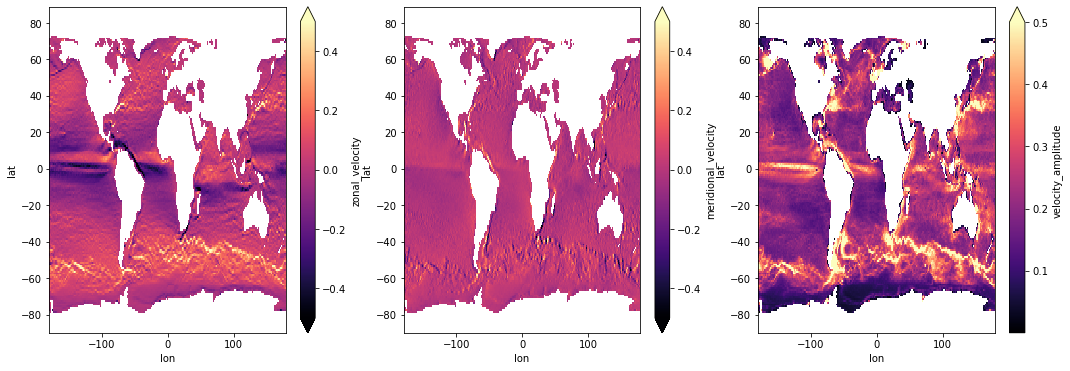

In [20]:
columns = ['zonal_velocity','meridional_velocity','velocity_amplitude']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')

#### Mean flow : Total velocity minus interpolated Eulerian mean, $<u_i'>=<u-\bar u_i>$
$<.>$ : average over bin and time

$\bar .$ : temporal average

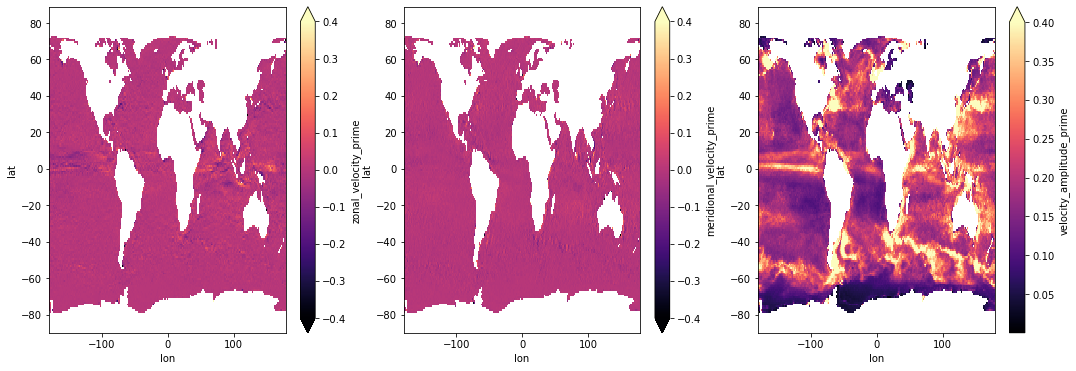

In [7]:
columns = ['zonal_velocity_prime','meridional_velocity_prime','velocity_amplitude_prime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')

#### Variance : $<u^2>$
$<.>$ : average over bin and time

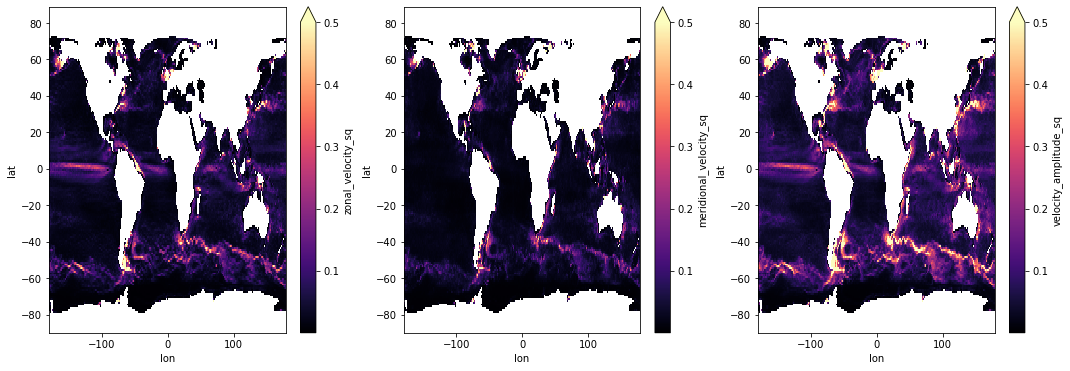

In [19]:
columns = ['zonal_velocity','meridional_velocity','velocity_amplitude']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean[V+'_sq'].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')

#### EKE : interpolated mean, $<u_i'^2>=<(u-\bar u_i)^2>$
$<.>$ : average over bin and time

$\bar .$ : temporal average

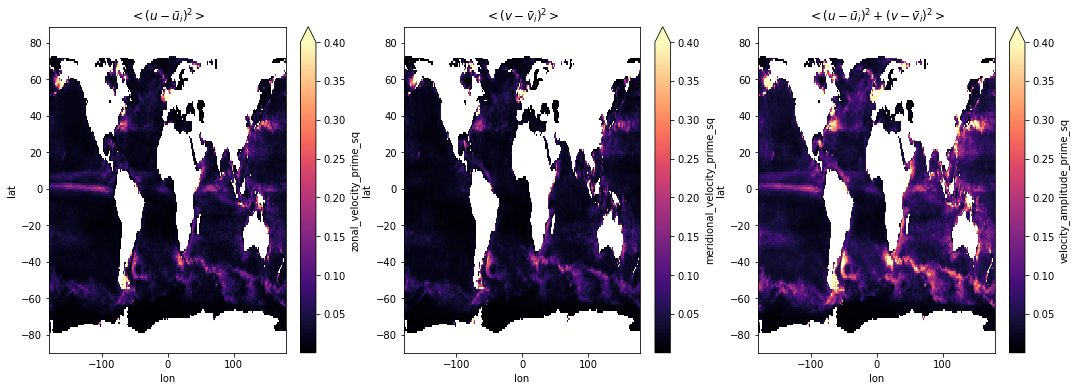

In [10]:
columns = ['zonal_velocity_prime','meridional_velocity_prime','velocity_amplitude_prime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<(u-\bar u_i)^2>$',r'$<(v-\bar v_i)^2>$',r'$<(u-\bar u_i)^2+(v-\bar v_i)^2>$']):
    df_mean[V+'_sq'].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### rms : interpolated mean, $\sqrt{<u_i'^2>}=\sqrt{<(u-\bar u_i)^2>}$
$<.>$ : average over bin and time

$\bar .$ : temporal average

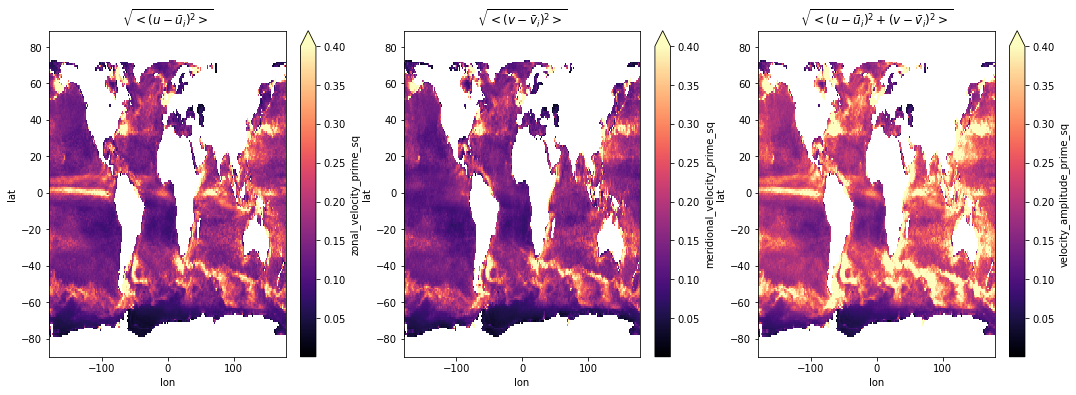

In [11]:
columns = ['zonal_velocity_prime','meridional_velocity_prime','velocity_amplitude_prime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax, title in zip(columns,axs,[r'$\sqrt{<(u-\bar u_i)^2>}$',r'$\sqrt{<(v-\bar v_i)^2>}$',r'$\sqrt{<(u-\bar u_i)^2+(v-\bar v_i)^2>}$']):
    np.sqrt(df_mean[V+'_sq']).plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### Total velocity minus binned Lagrangian mean, $u'_b$ : 

In [7]:
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
D = ["mean", "mean_square"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])

grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid])
ds = ds.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC
ds.load()

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, i_g: 1080, j: 1080, j_g: 1080)
Coordinates: (12/20)
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                (i) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * j                (j) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * i_g              (i_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
  * j_g              (j_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
    CS               (face, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...               ...
    dyC              (face, j_g, i) float32 239.5 239.5 239.6 ... 324.6 324.6
    dyG              (face, j, i_g) float32 479.0 479.1 479.2 ... 324.6 324.6
    rA               (face, j, i) float32 1.555e+05 1.555e+05 ... 1.556e+05
    rAs              (face, j_g, i) float32 7.774e+04 7.776e+04 ... 1.556e+05
    rAw              (face, j, i_g) float32 1.555e+05 1.555e+05 ... 1.556e+05
    rAz              (face, j_g, i_g) float32 7.774e+04 7.776e+04 ... 1.556e+05
Data variables:
    mean_Eta         (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_Eta  (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_SSU         (face, j, i_g) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SSU  (face, j, i_g) float32 nan nan nan nan ... nan nan nan nan
    mean_SSV         (face, j_g, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SSV  (face, j_g, i) float32 nan nan nan nan ... nan nan nan nan
    mean_SST         (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SST  (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_SSS         (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SSS  (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    lon              (face, j, i) float64 -114.9 -114.9 -114.9 ... -114.0 -114.5
    lat              (face, j, i) float64 -88.18 -88.19 -88.2 ... -88.17 -88.17

In [8]:
# Rotation velocity field
U_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.CS - ds.mean_SSV.rename({'j_g': 'j'})*ds.SN
V_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.SN + ds.mean_SSV.rename({'j_g': 'j'})*ds.CS

U_mean['lon'] = 0*ds.face+ds.XC
U_mean['lat'] = 0*ds.face+ds.YC

V_mean['lon'] = 0*ds.face+ds.XC
V_mean['lat'] = 0*ds.face+ds.YC

In [9]:
# Mean Eulerian field Dataset
ds_mean = xr.Dataset({'meridional_velocity_mean':V_mean,'zonal_velocity_mean':U_mean,
                      'sea_level_mean':ds.mean_Eta,'temperature_mean':ds.mean_SST,'salinity_mean':ds.mean_SSS})

In [10]:
ds_mean

<xarray.Dataset>
Dimensions:                   (face: 13, i: 1080, j: 1080)
Coordinates: (12/17)
  * face                      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                         (j) int64 0 4 8 12 16 ... 4300 4304 4308 4312 4316
  * i                         (i) int64 0 4 8 12 16 ... 4300 4304 4308 4312 4316
    dxC                       (face, j, i) float32 324.6 324.6 ... 480.3 479.5
    dyG                       (face, j, i) float32 479.0 479.1 ... 324.6 324.6
    rAw                       (face, j, i) float32 1.555e+05 ... 1.556e+05
    ...                        ...
    rA                        (face, j, i) float32 1.555e+05 ... 1.556e+05
    dxG                       (face, j, i) float32 324.6 324.6 ... 480.1 479.3
    dyC                       (face, j, i) float32 239.5 239.5 ... 324.6 324.6
    rAs                       (face, j, i) float32 7.774e+04 ... 1.556e+05
    lon                       (face, j, i) float64 -114.9 -114.9 ... -114.5
    lat                       (face, j, i) float64 -88.18 -88.19 ... -88.17
Data variables:
    meridional_velocity_mean  (face, j, i) float32 nan nan nan ... nan nan nan
    zonal_velocity_mean       (face, j, i) float32 nan nan nan ... nan nan nan
    sea_level_mean            (face, j, i) float32 nan nan nan ... nan nan nan
    temperature_mean          (face, j, i) float32 nan nan nan ... nan nan nan
    salinity_mean             (face, j, i) float32 nan nan nan ... nan nan nan

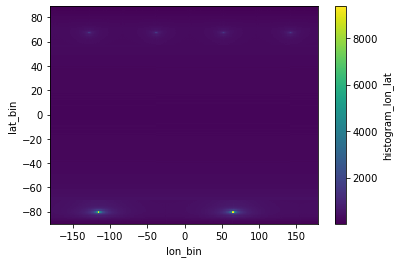

In [11]:
from xhistogram.xarray import histogram

dl = 1
lon = np.arange(-180.,180., dl)
lat = np.arange(-90., 90., dl)

N = histogram(ds.lon, ds.lat, bins=[lon, lat], dim=['i', 'j', 'face'], block_size=None)
N.plot(x='lon_bin',y='lat_bin')

In [20]:
ds_mean

<xarray.Dataset>
Dimensions:                   (face: 13, i: 1080, j: 1080)
Coordinates: (12/17)
  * face                      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                         (j) int64 0 4 8 12 16 ... 4300 4304 4308 4312 4316
  * i                         (i) int64 0 4 8 12 16 ... 4300 4304 4308 4312 4316
    dxC                       (face, j, i) float32 324.6 324.6 ... 480.3 479.5
    dyG                       (face, j, i) float32 479.0 479.1 ... 324.6 324.6
    rAw                       (face, j, i) float32 1.555e+05 ... 1.556e+05
    ...                        ...
    rA                        (face, j, i) float32 1.555e+05 ... 1.556e+05
    dxG                       (face, j, i) float32 324.6 324.6 ... 480.1 479.3
    dyC                       (face, j, i) float32 239.5 239.5 ... 324.6 324.6
    rAs                       (face, j, i) float32 7.774e+04 ... 1.556e+05
    lon                       (face, j, i) float64 -114.9 -114.9 ... -114.5
    lat                       (face, j, i) float64 -88.18 -88.19 ... -88.17
Data variables:
    meridional_velocity_mean  (face, j, i) float32 nan nan nan ... nan nan nan
    zonal_velocity_mean       (face, j, i) float32 nan nan nan ... nan nan nan
    sea_level_mean            (face, j, i) float32 nan nan nan ... nan nan nan
    temperature_mean          (face, j, i) float32 nan nan nan ... nan nan nan
    salinity_mean             (face, j, i) float32 nan nan nan ... nan nan nan

In [21]:
E_KE = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (ds_mean.zonal_velocity_mean), 
                 dim=['i', 'j','face'],
                 block_size=None
                )
E_KE_mean = (E_KE/N).rename('E_KE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

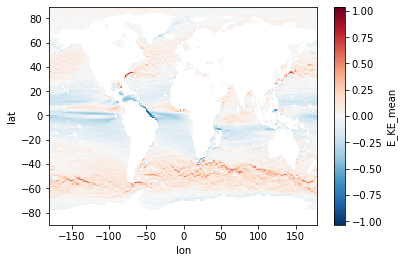

In [22]:
E_KE_mean.T.plot()

In [23]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
